In [9]:
#import relevant packages and libraies
import os
import re
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


In [11]:
df = pd.read_csv('data/driver_imgs_list.csv')
df.head(10)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
5,p002,c0,img_3370.jpg
6,p002,c0,img_67639.jpg
7,p002,c0,img_58560.jpg
8,p002,c0,img_35779.jpg
9,p002,c0,img_10012.jpg


In [21]:
df.groupby('classname').count()


,subject,img
classname,,
c0,2489,2489
c1,2267,2267
c2,2317,2317
c3,2346,2346
c4,2326,2326
c5,2312,2312
c6,2325,2325
c7,2002,2002
c8,1911,1911


In [42]:
X = []
y = []
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
base_path = './data/train/'

for i, target in enumerate(classes):
    
    files = os.listdir(base_path+target)
    
    for file in files:
        
        # load the image
        img = load_img(base_path+target + '/' + file, target_size=(224, 224))
        
        # convert it to an array
        img_array = np.array(img)
        
        # append the array to X
        X.append(img_array)
        
        # append the numeric target to y
        y.append(i)  

In [1]:
y

NameError: name 'y' is not defined

In [44]:
situations = {
                'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'
}

In [45]:
X = np.array(X)
y = np.array(y)

In [46]:
X.shape

(22424, 224, 224, 3)

In [47]:
# shuffle the data
shuffler = np.random.permutation(len(X))
X = X[shuffler]
y = y[shuffler]

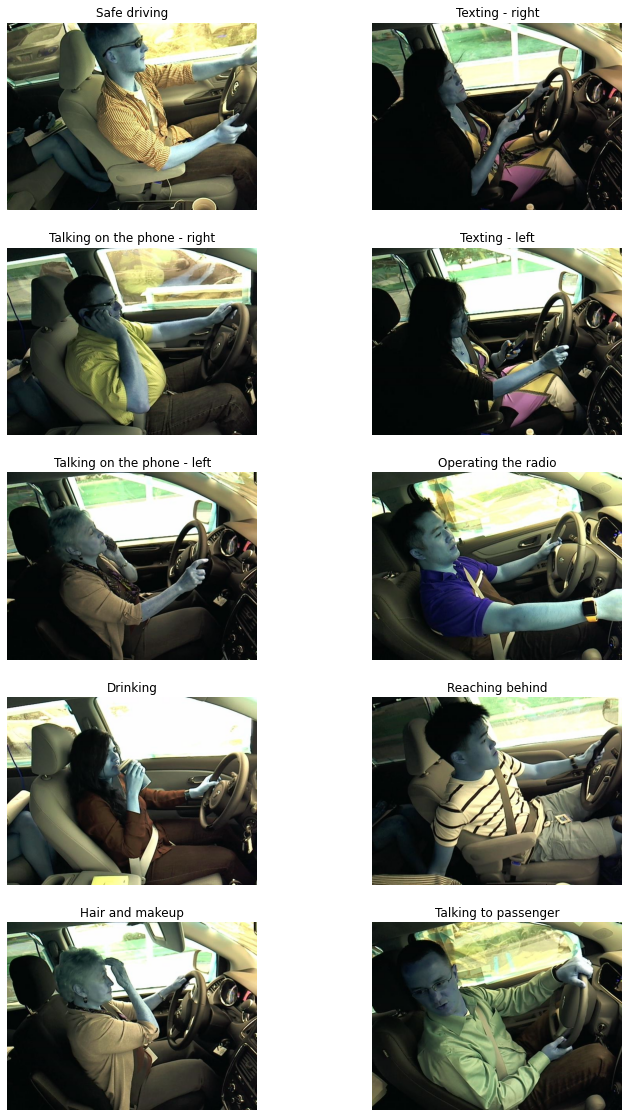

In [61]:
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = './data/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.axis('off')
                plt.title(situations[directory])

In [63]:
#one hot encode the labels
y = to_categorical(y)

# CNN Model

In [64]:
#clear session and build model
K.clear_session()

In [65]:
model_cnn = Sequential([
    Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = "valid", activation = "relu" ,input_shape = (224,224,3)),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = "valid"),
    
    Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = "valid", activation = "relu" ,input_shape = (224,224,3)),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = "valid"),
    
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = "valid", activation = "relu"),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = "valid"),
    
    Flatten(),
    
    #fully connected layers
    
    Dense(100,activation='relu'),
    
    #batch normalisation
    BatchNormalization(),
    
    #dropout 
    Dropout(0.2),
    
    #output layer
    Dense(10 ,activation= "softmax")

    
])

In [66]:
#check the summary:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0

In [67]:
#define early stopping for fitting
early_stop = keras.callbacks.EarlyStopping(
                                            monitor='val_loss', 
                                            min_delta=0.0005, 
                                            patience=3,
                                            verbose=1, 
                                            mode='auto',
                                           )

In [68]:
#compile the model
model_cnn.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [69]:
#fit the model
history = model_cnn.fit(X, y, batch_size=50, epochs=50,validation_split=0.2, callbacks=[early_stop])

Epoch 1/50
359/359 [==============================] - 1111s 3s/step - loss: 0.4654 - accuracy: 0.8718 - val_loss: 0.2511 - val_accuracy: 0.9237
Epoch 2/50
359/359 [==============================] - 1047s 3s/step - loss: 0.0537 - accuracy: 0.9907 - val_loss: 0.0868 - val_accuracy: 0.9790
Epoch 3/50
359/359 [==============================] - 29102s 81s/step - loss: 0.0230 - accuracy: 0.9962 - val_loss: 0.0306 - val_accuracy: 0.9926
Epoch 4/50
359/359 [==============================] - 1253s 3s/step - loss: 0.0168 - accuracy: 0.9974 - val_loss: 0.0651 - val_accuracy: 0.9784
Epoch 5/50
359/359 [==============================] - 2270s 6s/step - loss: 0.0126 - accuracy: 0.9984 - val_loss: 0.0283 - val_accuracy: 0.9922
Epoch 6/50
359/359 [==============================] - 1851s 5s/step - loss: 0.0159 - accuracy: 0.9966 - val_loss: 3.6537 - val_accuracy: 0.5090
Epoch 7/50
359/359 [==============================] - 1639s 5s/step - loss: 0.0159 - accuracy: 0.9965 - val_loss: 0.0405 - val_accurac

# Examine the model

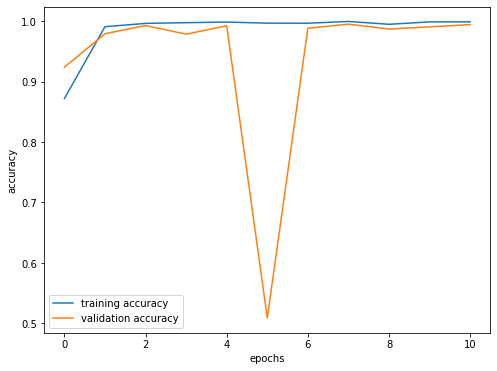

In [70]:
#plot accuracy curve
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label= 'validation accuracy')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()


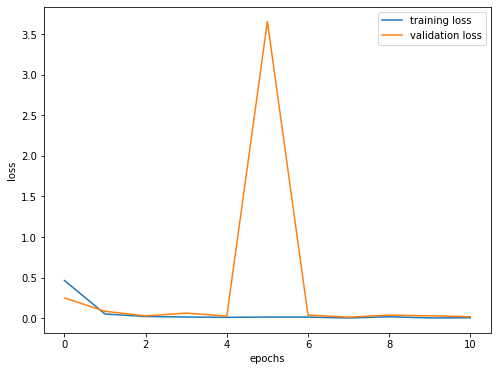

In [71]:
# Plot loss
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [75]:
X_test = []
base_path = './data/test/'


files = os.listdir(base_path)
for file in files:
    # load the image
    img = load_img(base_path+'/'+file,target_size=(224, 224) )
    # convert it to an array
    img_array = np.array(img)
        
    # append the array to X
    X_test.append(img_array)
        

In [76]:
X_test = np.array(X_test)

In [77]:
ypred = model_cnn.predict(X_test)

In [78]:
#look at the first prediction
ypred[0]

array([2.5442850e-08, 5.1965439e-11, 2.1485542e-07, 5.2364152e-10,
       5.8239125e-09, 9.9999869e-01, 2.7229125e-11, 6.2721648e-07,
       3.1820402e-08, 4.9981782e-07], dtype=float32)

In [84]:
np.argmax(ypred[0])

5

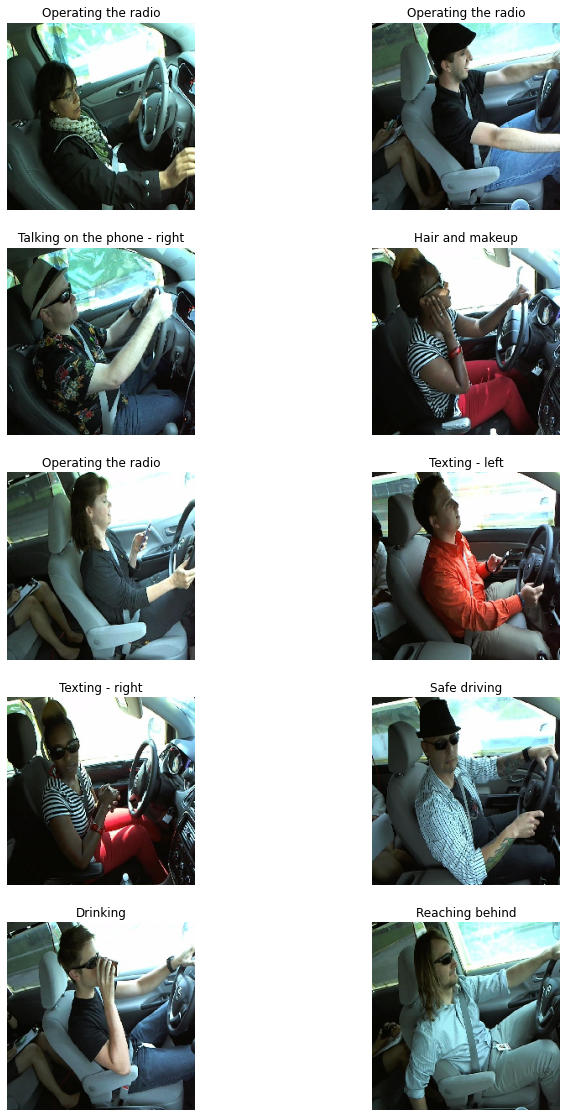

In [98]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,20
# have a look at the data
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(situations[classes[np.argmax(ypred[i])]]) 

In [73]:
model_cnn.save('./models/model_cnn_wout_lr_full.h5')